In [28]:
import numpy as np
import torch
from transformers import *
from sklearn.cluster import KMeans
import time
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [29]:
train_embeddings = {}
test_embeddings = {}
sents = np.load('sentences.npy')
vectors = np.load('vectors.npy')
domain = np.load('domain.npy')
sentiment = np.load('sentiment.npy')

split = int(0.8 * len(sents))
train_embeddings['sents'] = sents[:split]
train_embeddings['vectors'] = vectors[:split]
train_embeddings['domain'] = domain[:split]
train_embeddings['sentiment'] = sentiment[:split]
test_embeddings['sents'] = sents[split:]
test_embeddings['vectors'] = vectors[split:]
test_embeddings['domain'] = domain[split:]
test_embeddings['sentiment'] = sentiment[split:]

In [49]:
DOMAINS = ['Automotive', 'Books', 'Music', 'Software', 'Baby']
N_CLUSTERS = 5

def kmeans(train_data, num_clusters=5):
    model = KMeans(n_clusters=num_clusters,
                   max_iter=250,
                   random_state=1,
                   verbose=1)
    
    model.fit(train_data)
    return model


def get_predictions(model, test_data):
    return model.predict(test_data)


def assign_labels_to_clusters(true_labels, predictions, num_clusters=8):
    cluster_assignment = {}
    true_count = 0
    total = 0
    for k in range(num_clusters):
        count = [0] * len(DOMAINS)
        for i, pred in enumerate(predictions):
            if pred == k:
                count[DOMAINS.index(true_labels[i])] += 1
        max_count = max(count)
        total_count = sum(count)
        cluster_assignment[k] = (DOMAINS[count.index(max_count)], max_count, total_count)
        true_count += max_count
        total += total_count
    acc = true_count / total
    return cluster_assignment, acc


def calc_test_accuracy(true_labels, predictions, cluster_assignment):
    total = 0
    true_count = 0
    for i, pred in enumerate(predictions):
        if cluster_assignment[pred][0] == true_labels[i]:
            true_count +=1
        total += 1
    return true_count / total

In [50]:
start = time.time()
model = kmeans(train_embeddings['vectors'], N_CLUSTERS)
end  = time.time()
print(f"Time taken to converge: {(end-start) / 3600} hrs.")

Initialization complete
Iteration 0, inertia 632496.0625
Iteration 1, inertia 394097.625
Iteration 2, inertia 386539.4375
Iteration 3, inertia 382001.1875
Iteration 4, inertia 379790.6875
Iteration 5, inertia 378183.28125
Iteration 6, inertia 376053.46875
Iteration 7, inertia 373897.875
Iteration 8, inertia 372121.1875
Iteration 9, inertia 371067.65625
Iteration 10, inertia 370710.84375
Iteration 11, inertia 370626.125
Iteration 12, inertia 370605.6875
Iteration 13, inertia 370599.75
Iteration 14, inertia 370597.4375
Iteration 15, inertia 370596.78125
Iteration 16, inertia 370596.21875
Iteration 17, inertia 370595.8125
Iteration 18, inertia 370595.71875
Iteration 19, inertia 370595.34375
Iteration 20, inertia 370595.3125
Iteration 21, inertia 370595.125
Iteration 22, inertia 370595.0
Iteration 23, inertia 370595.09375
Iteration 24, inertia 370595.125
Converged at iteration 24: center shift 4.3078617295577715e-07 within tolerance 1.4255304820835591e-06.
Initialization complete
Iteration

Iteration 13, inertia 365001.71875
Iteration 14, inertia 365000.0
Iteration 15, inertia 364998.9375
Iteration 16, inertia 364998.28125
Iteration 17, inertia 364997.875
Iteration 18, inertia 364997.6875
Iteration 19, inertia 364997.5625
Iteration 20, inertia 364997.625
Converged at iteration 20: center shift 8.638885446998756e-07 within tolerance 1.4255304820835591e-06.
Initialization complete
Iteration 0, inertia 592545.875
Iteration 1, inertia 387703.4375
Iteration 2, inertia 379106.53125
Iteration 3, inertia 374236.3125
Iteration 4, inertia 371653.46875
Iteration 5, inertia 369646.6875
Iteration 6, inertia 367493.8125
Iteration 7, inertia 366293.0625
Iteration 8, inertia 365690.1875
Iteration 9, inertia 365369.21875
Iteration 10, inertia 365202.46875
Iteration 11, inertia 365115.375
Iteration 12, inertia 365069.21875
Iteration 13, inertia 365041.8125
Iteration 14, inertia 365026.9375
Iteration 15, inertia 365017.78125
Iteration 16, inertia 365012.0625
Iteration 17, inertia 365008.218

In [51]:
train_pred = get_predictions(model, train_embeddings['vectors'])
cluster_assignment, accuracy = assign_labels_to_clusters(train_embeddings['domain'], train_pred, N_CLUSTERS)
print(f"Train accuracy is {accuracy:.4f}")

test_pred = get_predictions(model, test_embeddings['vectors'])
test_accuracy = calc_test_accuracy(test_embeddings['domain'], test_pred, cluster_assignment)
print(f"Test accuracy is {test_accuracy:.4f}")

np.save('test_pred_kmeans_k5_distilBERT.npy', test_pred)

Train accuracy is 0.7314
Test accuracy is 0.7399


In [52]:
for k in range(N_CLUSTERS):
    print(f'Cluster-{k+1} | label: {cluster_assignment[k][0]} | Purity: {cluster_assignment[k][1]/cluster_assignment[k][2]}')

Cluster-1 | label: Books | Purity: 0.8970831741179468
Cluster-2 | label: Automotive | Purity: 0.4526610644257703
Cluster-3 | label: Software | Purity: 0.8810560314562561
Cluster-4 | label: Music | Purity: 0.9778405081157375
Cluster-5 | label: Baby | Purity: 0.5232761360025421


In [53]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

tsne = TSNE(n_components=2, verbose=1, random_state=1)
z = tsne.fit_transform(test_embeddings['vectors'])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...


/opt/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 10000 samples in 2.844s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.795489
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.616371
[t-SNE] KL divergence after 1000 iterations: 2.670528


<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

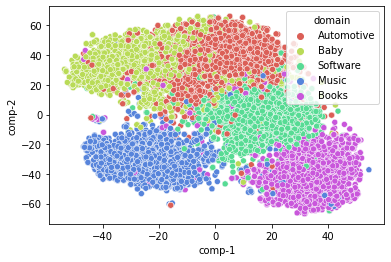

In [54]:
df = pd.DataFrame()
df["domain"] = test_embeddings['domain']
df["clusters"] = [cluster_assignment[pred][0] for pred in test_pred]
# df["clusters"] = test_pred
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue="domain", palette=sns.color_palette("hls", 5))

<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

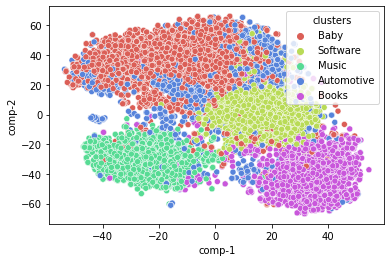

In [55]:
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue="clusters", palette=sns.color_palette("hls", 5))